# ML & Generating Predictions Notebook 03
This notebook is where we will evaluate baseline and candidate models to see which model we should use as our primary.  

*Note: We did not perform feature selection because the dataset contains only twelve clinically meaningful features, and removing any of them could discard useful non-linear or interaction effects. Simple correlation is not a reliable indicator of predictive value, especially in medical data. Several models we use, including Random Forests, Gradient Boosting, and regularized Logistic Regression, already perform built-in feature selection or regularization by down-weighting weaker predictors. Because these models naturally handle feature relevance, explicit feature elimination is unnecessary for this project. We will analyze feature importance in a future step* 

In [58]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# XGBoost
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    roc_curve,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

# Helper functions
import sys
sys.path.append('../')
from helper_funcs.evals import evaluate_model

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
np.random.seed(42)


In [59]:
# Results Dict
all_results = {}

### We will create a baseline logistic regression for our actual models to outperform

In [60]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [61]:
# Load data - splits were created in previous notebook 
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()  # Convert to 1D array

X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()  # Convert to 1D array

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")

Training set: 179 samples
Validation set: 45 samples
Class distribution in training: [130  49]
Class distribution in validation: [33 12]


In [62]:
# create pipeline and run logistic regression

# Column Transformer + Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# Example pipeline with logistic regression, will redo this part in the ML notebook
baseline_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear',class_weight='balanced'))]
)

In [63]:
# Train the baseline model
baseline_lr_pipeline.fit(X_train, y_train)

# Make predictions on VALIDATION set
y_val_pred = baseline_lr_pipeline.predict(X_val)
y_val_pred_proba = baseline_lr_pipeline.predict_proba(X_val)[:, 1]  # Probability of death

print("Baseline Logistic Regression trained successfully!")


Baseline Logistic Regression trained successfully!


In [64]:
# evaluate_model function is now imported from helper_funcs.evals
# See helper_funcs/evals.py for the function definition


EVALUATION METRICS: Baseline Logistic Regression

ACCURACY: 0.7556 (75.56%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.5833 (58.33%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 58.3% of actual deaths

PRECISION: 0.5385 (53.85%)
Of all predicted deaths, what % were correct?
53.8% of predicted deaths were real

F1 SCORE: 0.5600
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8409
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    27  | Correctly predicted survived
False Positives (FP):    6  | Incorrectly predicted death
False Negatives (FN):    5  | MISSED deaths 
True Positives (TP):     7  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusio

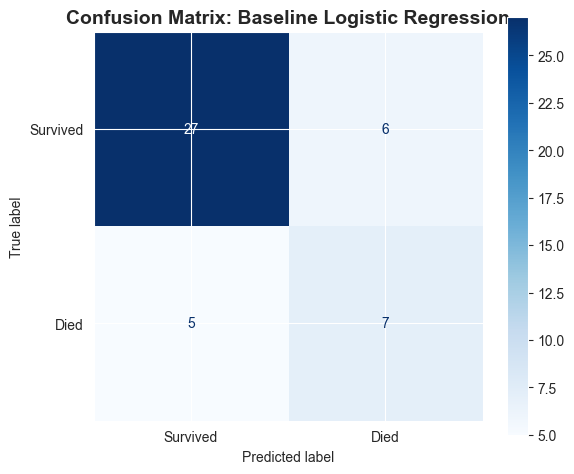


SUMMARY:
Accuracy: 0.756 | Recall: 0.583 | Precision: 0.538
F1 Score: 0.560 | ROC-AUC: 0.841
Missed Deaths (FN): 5 out of 12 (41.7%)



In [65]:
# Evaluate the Baseline Logistic Regression
evaluate_model(y_val, y_val_pred, y_val_pred_proba, model_name="Baseline Logistic Regression")


In [66]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Plot ROC curve for a single model.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title(f'ROC Curve: {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc


def plot_multiple_roc_curves(models_dict, y_true):
    """
    Plot multiple ROC curves on the same plot for comparison.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with format: {'Model Name': y_pred_proba, ...}
    y_true : array-like
        True labels
    """
    plt.figure(figsize=(10, 8))
    
    colors = ['darkorange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, (model_name, y_pred_proba) in enumerate(models_dict.items()):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        color = colors[i % len(colors)]
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


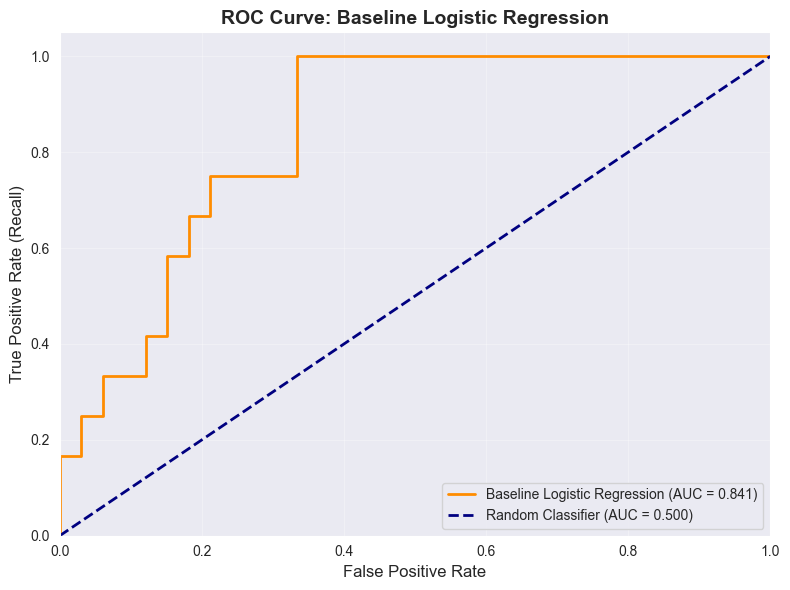

0.8409090909090909

In [67]:
# Plot ROC curve for baseline logistic regression
plot_roc_curve(y_val, y_val_pred_proba, model_name="Baseline Logistic Regression")


### Now we will use more complex models 

Notes:  
- We used 5-fold stratified cross-validation for model selection because the dataset is relatively small (299 samples). Five folds provide a good balance between bias and variance, produce stable performance estimates, and avoid the computational cost of higher-fold CV while still giving more reliable results than a single train/validation split.
- We will use GridSearchCV to return the best model for each and to tune hyperparameters

### Logistic Regression
We will begin with logistic regression. We will: 
- Tune the regularization strength of logistic regression using GridSearchCV over C ∈ {0.01, 0.1, 1, 10, 100} with 5-fold cross-validation and ROC–AUC as the scoring metric.
- Selected the C_i that produced the highest mean cross-validated ROC-AUC on thr training set.
- Refit the model with optimal C

In [68]:
# Set up the pipeline 
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000, random_state=42,penalty='l2'))
])

# Define the hyperparameter grid - trying different regularization strengths
c_vals = [i * 0.0001 for i in range(1, 15)]
c_vals.append(0.01)
c_vals.append(0.1)
param_grid = {
    'classifier__C': c_vals  # Lower C = stronger regularization
}

print(f"Testing {len(c_vals)} different C values with 5-fold CV")

# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV - this will try all C values and pick the best one
grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Most important metric for us
    n_jobs=-1,  # Use all CPU cores
    verbose=0
)

# Fit - this runs all the cross-validation
grid_search.fit(X_train, y_train)

print("\nGrid search complete!")


Testing 16 different C values with 5-fold CV

Grid search complete!


In [69]:
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validated ROC-AUC score: {grid_search.best_score_:.4f}")

# Look at all the results to see how each C performed
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nAll cross-validation results:")
print(results_df[['param_classifier__C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


Best parameters found:
{'classifier__C': 0.0012000000000000001}

Best cross-validated ROC-AUC score: 0.9109

All cross-validation results:
    param_classifier__C  mean_test_score  std_test_score
11               0.0012         0.910940        0.044627
12               0.0013         0.910940        0.044627
13               0.0014         0.910940        0.044627
9                0.0010         0.909231        0.043961
10               0.0011         0.909231        0.043961
8                0.0009         0.908462        0.045469
0                0.0001         0.908376        0.042069
1                0.0002         0.908376        0.042069
2                0.0003         0.907607        0.043560
3                0.0004         0.907607        0.043560
5                0.0006         0.907607        0.045226
6                0.0007         0.907607        0.045226
7                0.0008         0.907607        0.045226
4                0.0005         0.906838        0.045054
14    

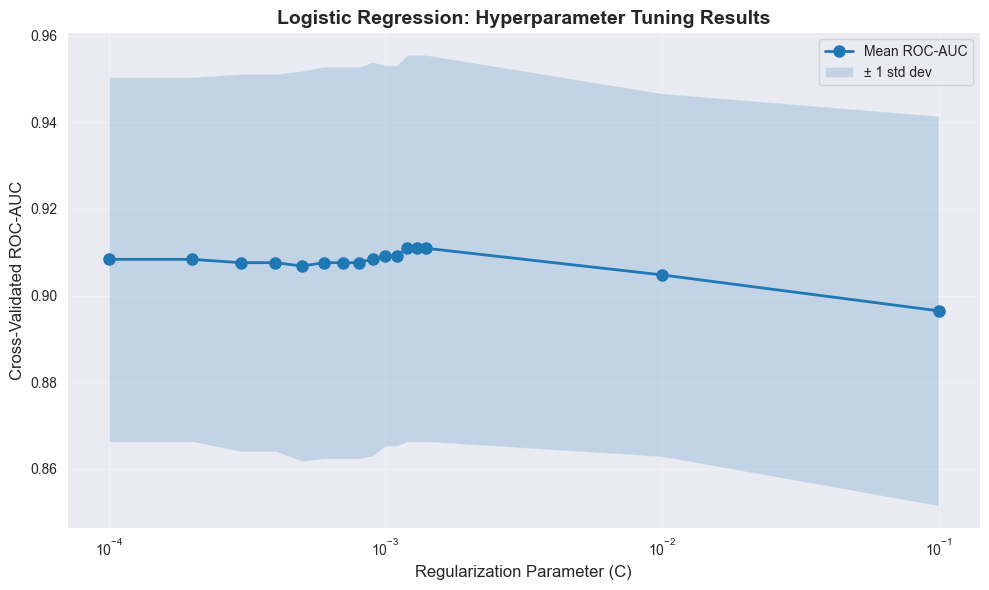

In [70]:
# Visualize how performance changes with C
plt.figure(figsize=(10, 6))
mean_scores = results_df['mean_test_score'].values
std_scores = results_df['std_test_score'].values

plt.semilogx(c_vals, mean_scores, 'o-', linewidth=2, markersize=8, label='Mean ROC-AUC')
plt.fill_between(c_vals, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, label='± 1 std dev')
plt.xlabel('Regularization Parameter (C)', fontsize=12)
plt.ylabel('Cross-Validated ROC-AUC', fontsize=12)
plt.title('Logistic Regression: Hyperparameter Tuning Results', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Interesting to see - lower C means more regularization (simpler model)
# Higher C means less regularization (more complex model)


In [71]:
# The best model is already refitted on the full training set by GridSearchCV
# We can access it directly
tuned_lr_model = grid_search.best_estimator_

# Make predictions on validation set
y_val_pred_tuned = tuned_lr_model.predict(X_val)
y_val_pred_proba_tuned = tuned_lr_model.predict_proba(X_val)[:, 1]

print("Tuned Logistic Regression ready for evaluation!")


Tuned Logistic Regression ready for evaluation!


EVALUATION METRICS: Tuned Logistic Regression

ACCURACY: 0.8000 (80.00%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.9167 (91.67%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 91.7% of actual deaths

PRECISION: 0.5789 (57.89%)
Of all predicted deaths, what % were correct?
57.9% of predicted deaths were real

F1 SCORE: 0.7097
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8712
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    25  | Correctly predicted survived
False Positives (FP):    8  | Incorrectly predicted death
False Negatives (FN):    1  | MISSED deaths 
True Positives (TP):    11  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion M

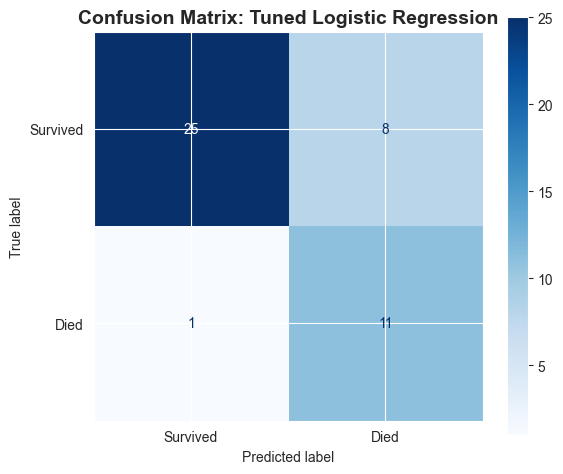


SUMMARY:
Accuracy: 0.800 | Recall: 0.917 | Precision: 0.579
F1 Score: 0.710 | ROC-AUC: 0.871
Missed Deaths (FN): 1 out of 12 (8.3%)



In [72]:
# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned, y_val_pred_proba_tuned, model_name="Tuned Logistic Regression")


COMPARISON: Baseline vs Tuned Logistic Regression
  Metric  Baseline LR  Tuned LR  Improvement
 ROC-AUC     0.840909  0.871212     0.030303
  Recall     0.583333  0.916667     0.333333
F1 Score     0.560000  0.709677     0.149677


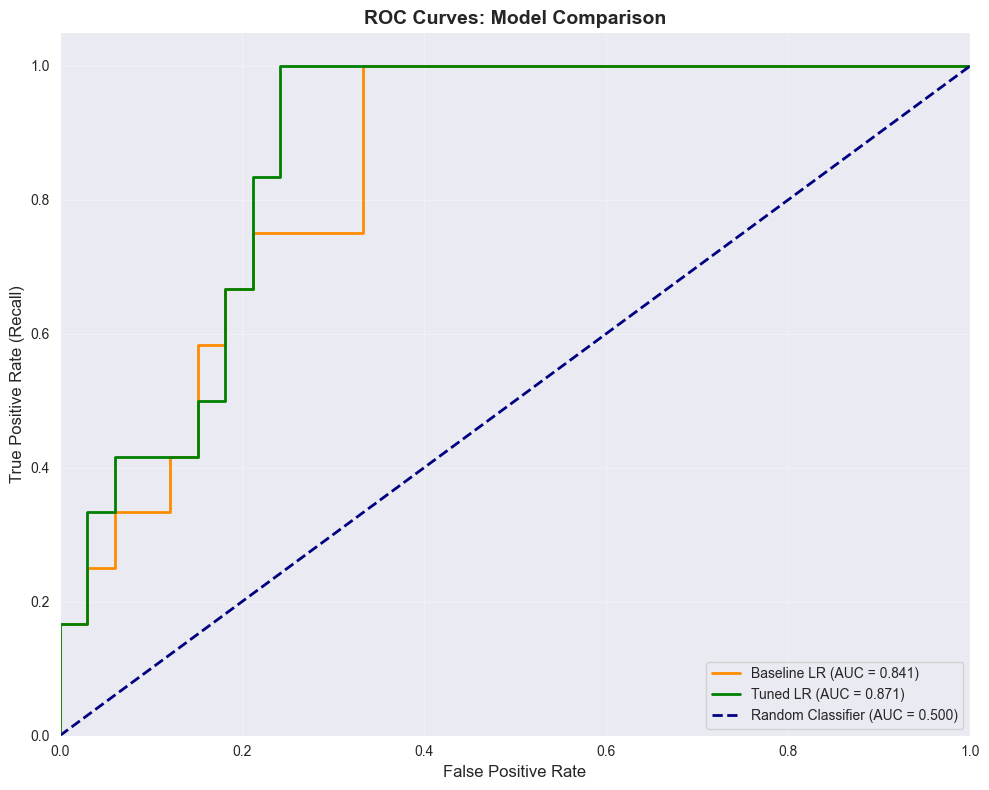

In [73]:
# Compare baseline vs tuned logistic regression
print("="*70)
print("COMPARISON: Baseline vs Tuned Logistic Regression")
print("="*70)

# Calculate metrics for both
baseline_auc = roc_auc_score(y_val, y_val_pred_proba)
tuned_auc = roc_auc_score(y_val, y_val_pred_proba_tuned)

baseline_recall = recall_score(y_val, y_val_pred, pos_label=1)
tuned_recall = recall_score(y_val, y_val_pred_tuned, pos_label=1)

baseline_f1 = f1_score(y_val, y_val_pred, pos_label=1)
tuned_f1 = f1_score(y_val, y_val_pred_tuned, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned LR': [tuned_auc, tuned_recall, tuned_f1],
    'Improvement': [tuned_auc - baseline_auc, tuned_recall - baseline_recall, tuned_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned LR': y_val_pred_proba_tuned
}
plot_multiple_roc_curves(models_dict, y_val)


In [74]:
# Store results for later comparison with other models
lr_results = {
    'model_name': 'Logistic Regression (Tuned)',
    'model': tuned_lr_model,
    'y_pred': y_val_pred_tuned,
    'y_pred_proba': y_val_pred_proba_tuned,
    'roc_auc': tuned_auc,
    'recall': tuned_recall,
    'f1': tuned_f1,
    'best_params': grid_search.best_params_
}

all_results['Logistic Regression (Tuned)'] = lr_results
print("Saved results for LR (Tuned)")


Saved results for LR (Tuned)


### Decision Trees
We will follow the same structure from above. We will use GridSearchCV to run cross validation as well as find optimal hyperparameters

In [75]:
# Init Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define Hyperparameter Grid
param_grid = {
    'classifier__max_depth': [2, 3, 4, 5, 7, 9, 11, 13, 15, None],    
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [76]:
# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch
grid_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit - this runs all the cross-validation
grid_dt.fit(X_train, y_train)

print("\nGrid search complete!")



Grid search complete!


In [77]:
print("Best params:", grid_dt.best_params_)
print("Best ROC-AUC:", grid_dt.best_score_)

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best ROC-AUC: 0.8491880341880341


In [78]:
# Let's look at all results
results_df = pd.DataFrame(grid_dt.cv_results_)
print("\nAll cross-validation results:")
print(results_df[['param_classifier__max_depth', 'param_classifier__min_samples_split', 'param_classifier__min_samples_leaf' ,'param_classifier__min_samples_leaf','param_classifier__criterion', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


All cross-validation results:
    param_classifier__max_depth  param_classifier__min_samples_split  \
116                           4                                   10   
114                           4                                    2   
115                           4                                    5   
5                             2                                   10   
1                             2                                    5   
..                          ...                                  ...   
54                           11                                    2   
45                            9                                    2   
21                            4                                    2   
22                            4                                    5   
36                            7                                    2   

     param_classifier__min_samples_leaf  param_classifier__min_samples_leaf  \
116                      

EVALUATION METRICS: Tuned Decision Tree

ACCURACY: 0.8444 (84.44%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.7500 (75.00%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 75.0% of actual deaths

PRECISION: 0.6923 (69.23%)
Of all predicted deaths, what % were correct?
69.2% of predicted deaths were real

F1 SCORE: 0.7200
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8144
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    29  | Correctly predicted survived
False Positives (FP):    4  | Incorrectly predicted death
False Negatives (FN):    3  | MISSED deaths 
True Positives (TP):     9  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Matrix:

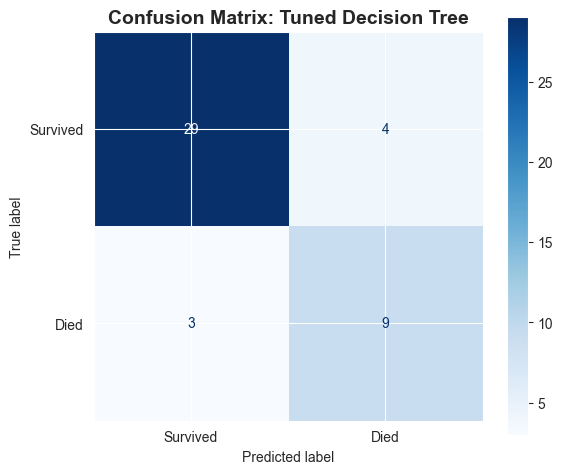


SUMMARY:
Accuracy: 0.844 | Recall: 0.750 | Precision: 0.692
F1 Score: 0.720 | ROC-AUC: 0.814
Missed Deaths (FN): 3 out of 12 (25.0%)



In [79]:
tuned_dt_model = grid_dt.best_estimator_

# Make predictions on validation set
y_val_pred_tuned_dt = tuned_dt_model.predict(X_val)
y_val_pred_proba_tuned_dt = tuned_dt_model.predict_proba(X_val)[:, 1]

# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned_dt, y_val_pred_proba_tuned_dt, model_name="Tuned Decision Tree")



COMPARISON: Baseline vs Tuned Decision Tree
  Metric  Baseline  LR  Tuned DT  Improvement
 ROC-AUC      0.840909  0.814394    -0.026515
  Recall      0.583333  0.750000     0.166667
F1 Score      0.560000  0.720000     0.160000


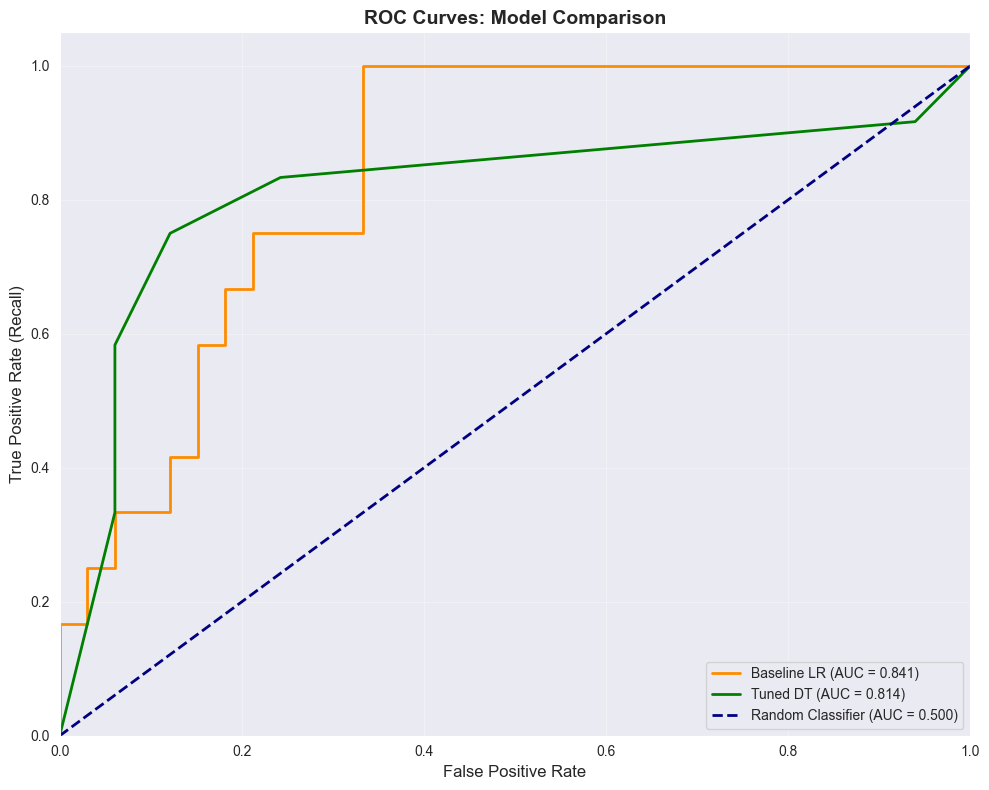

In [80]:
# Compare baseline vs tuned Decision Tree
print("="*70)
print("COMPARISON: Baseline vs Tuned Decision Tree")
print("="*70)

# Calculate metrics 
tuned_dt_auc = roc_auc_score(y_val, y_val_pred_proba_tuned_dt)

tuned_dt_recall = recall_score(y_val, y_val_pred_tuned_dt, pos_label=1)

tuned_dt_f1 = f1_score(y_val, y_val_pred_tuned_dt, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_dt_auc, tuned_dt_recall, tuned_dt_f1],
    'Improvement': [tuned_dt_auc - baseline_auc, tuned_dt_recall - baseline_recall, tuned_dt_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_val_pred_proba_tuned_dt
}
plot_multiple_roc_curves(models_dict, y_val)


In [81]:
# Store results for later comparison with other models
dt_results = {
    'model_name': 'Decision Tree (Tuned)',
    'model': tuned_dt_model,
    'y_pred': y_val_pred_tuned_dt,
    'y_pred_proba': y_val_pred_proba_tuned_dt,
    'roc_auc': tuned_dt_auc,
    'recall': tuned_dt_recall,
    'f1': tuned_dt_f1,
    'best_params': grid_dt.best_params_
}

all_results['Decision Tree (Tuned)'] = dt_results


### Let's Use Random Forests
We will again follow the same process for RF. 

In [82]:
# Init Pipeline and GridSearch Params
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),   # same ColumnTransformer as before
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_rf = {
    "model__n_estimators": [100, 125, 250],      # number of trees
    "model__max_depth": [None, 3, 4, 5, 7],         # tree depth
    "model__min_samples_split": [2, 5, 10],      # min samples to split
    "model__min_samples_leaf": [5, 8, 10, 11],        # min samples per leaf
    "model__max_features": ["sqrt", "log2"]      # how many features to consider at each split
}

# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="roc_auc", 
    cv=5,
    n_jobs=-1
)


In [83]:
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV ROC-AUC:", rf_grid.best_score_)

Best RF params: {'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 11, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best RF CV ROC-AUC: 0.9105128205128207


EVALUATION METRICS: Tuned Random Forest

ACCURACY: 0.8000 (80.00%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.3333 (33.33%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 33.3% of actual deaths

PRECISION: 0.8000 (80.00%)
Of all predicted deaths, what % were correct?
80.0% of predicted deaths were real

F1 SCORE: 0.4706
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.9343
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    32  | Correctly predicted survived
False Positives (FP):    1  | Incorrectly predicted death
False Negatives (FN):    8  | MISSED deaths 
True Positives (TP):     4  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Matrix:

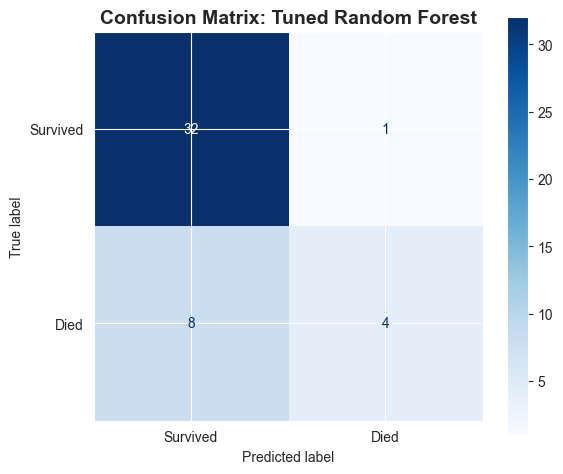


SUMMARY:
Accuracy: 0.800 | Recall: 0.333 | Precision: 0.800
F1 Score: 0.471 | ROC-AUC: 0.934
Missed Deaths (FN): 8 out of 12 (66.7%)



In [84]:
results_df = pd.DataFrame(rf_grid.cv_results_)

best_rf_model = rf_grid.best_estimator_

# Make predictions on validation set
y_val_pred_tuned_rf = best_rf_model.predict(X_val)
y_val_pred_proba_tuned_rf = best_rf_model.predict_proba(X_val)[:, 1]

# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned_rf, y_val_pred_proba_tuned_rf, model_name="Tuned Random Forest")

#### Threshold Tuning for Random Forest

Since the default threshold (0.5) resulted in poor recall, let's tune the classification threshold to improve our ability to catch deaths.


In [85]:
# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 17)

print("Random Forest - Threshold Tuning Results:")
print("="*70)
threshold_results_rf = []

for t in thresholds:
    y_pred_t = (y_val_pred_proba_tuned_rf >= t).astype(int)
    recall_t = recall_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    precision_t = precision_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    f1_t = f1_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    
    threshold_results_rf.append({
        'threshold': t,
        'recall': recall_t,
        'precision': precision_t,
        'f1': f1_t
    })
    
    print(f"t={t:.2f} | Recall={recall_t:.3f} | Precision={precision_t:.3f} | F1={f1_t:.3f}")

print("="*70)

# Find best threshold based on F1 score
threshold_df_rf = pd.DataFrame(threshold_results_rf)
best_threshold_rf = threshold_df_rf.loc[threshold_df_rf['f1'].idxmax()]

print(f"\nBest threshold for Random Forest: {best_threshold_rf['threshold']:.3f}")
print(f"  Recall: {best_threshold_rf['recall']:.3f}")
print(f"  Precision: {best_threshold_rf['precision']:.3f}")
print(f"  F1 Score: {best_threshold_rf['f1']:.3f}")

# Apply best threshold
y_pred_03 = (y_val_pred_proba_tuned_rf >= best_threshold_rf['threshold']).astype(int)

print(f"\nApplied threshold: {best_threshold_rf['threshold']:.3f}")

Random Forest - Threshold Tuning Results:
t=0.10 | Recall=1.000 | Precision=0.316 | F1=0.480
t=0.15 | Recall=1.000 | Precision=0.462 | F1=0.632
t=0.20 | Recall=1.000 | Precision=0.571 | F1=0.727
t=0.25 | Recall=0.917 | Precision=0.611 | F1=0.733
t=0.30 | Recall=0.833 | Precision=0.667 | F1=0.741
t=0.35 | Recall=0.833 | Precision=0.714 | F1=0.769
t=0.40 | Recall=0.750 | Precision=0.750 | F1=0.750
t=0.45 | Recall=0.667 | Precision=0.889 | F1=0.762
t=0.50 | Recall=0.333 | Precision=0.800 | F1=0.471
t=0.55 | Recall=0.333 | Precision=0.800 | F1=0.471
t=0.60 | Recall=0.250 | Precision=0.750 | F1=0.375
t=0.65 | Recall=0.083 | Precision=1.000 | F1=0.154
t=0.70 | Recall=0.083 | Precision=1.000 | F1=0.154
t=0.75 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.80 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.85 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.90 | Recall=0.000 | Precision=0.000 | F1=0.000

Best threshold for Random Forest: 0.350
  Recall: 0.833
  Precision: 0.714
  F1 Score: 0.7

COMPARISON: Baseline vs Tuned Random Forest (0.5)
  Metric  Baseline  LR  Tuned DT  Improvement
 ROC-AUC      0.840909  0.934343     0.093434
  Recall      0.583333  0.333333    -0.250000
F1 Score      0.560000  0.470588    -0.089412


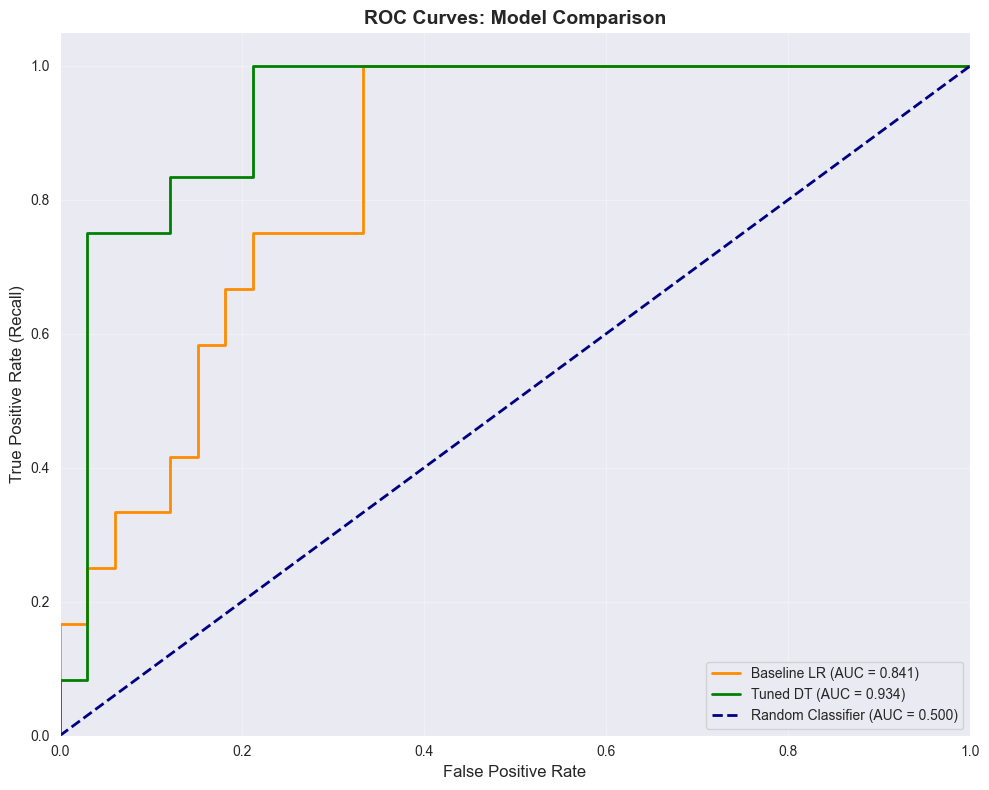

In [86]:
# Compare baseline vs tuned Random Forest
print("="*70)
print("COMPARISON: Baseline vs Tuned Random Forest (0.5)")
print("="*70)

# Calculate metrics
tuned_rf_auc = roc_auc_score(y_val, y_val_pred_proba_tuned_rf)
tuned_rf_recall = recall_score(y_val, y_val_pred_tuned_rf, pos_label=1)
tuned_rf_f1 = f1_score(y_val, y_val_pred_tuned_rf, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_rf_auc, tuned_rf_recall, tuned_rf_f1],
    'Improvement': [tuned_rf_auc - baseline_auc, tuned_rf_recall - baseline_recall, tuned_rf_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_val_pred_proba_tuned_rf
}
plot_multiple_roc_curves(models_dict, y_val)


In [87]:
# Store results for later comparison with other models
rf_results = {
    'model_name': 'Random Forest (Tuned)',
    'model': best_rf_model,
    'y_pred': y_val_pred_tuned_rf,
    'y_pred_proba': y_val_pred_proba_tuned_rf,
    'roc_auc': tuned_rf_auc,
    'recall': tuned_rf_recall,
    'f1': tuned_rf_f1,
    'best_params': rf_grid.best_params_
}

all_results['Random Forest (Tuned) (0.5)'] = rf_results

COMPARISON: Baseline vs Tuned Random Forest (0.225)
  Metric  Baseline  LR  Tuned DT  Improvement
 ROC-AUC      0.840909  0.856061     0.015152
  Recall      0.583333  0.833333     0.250000
F1 Score      0.560000  0.769231     0.209231


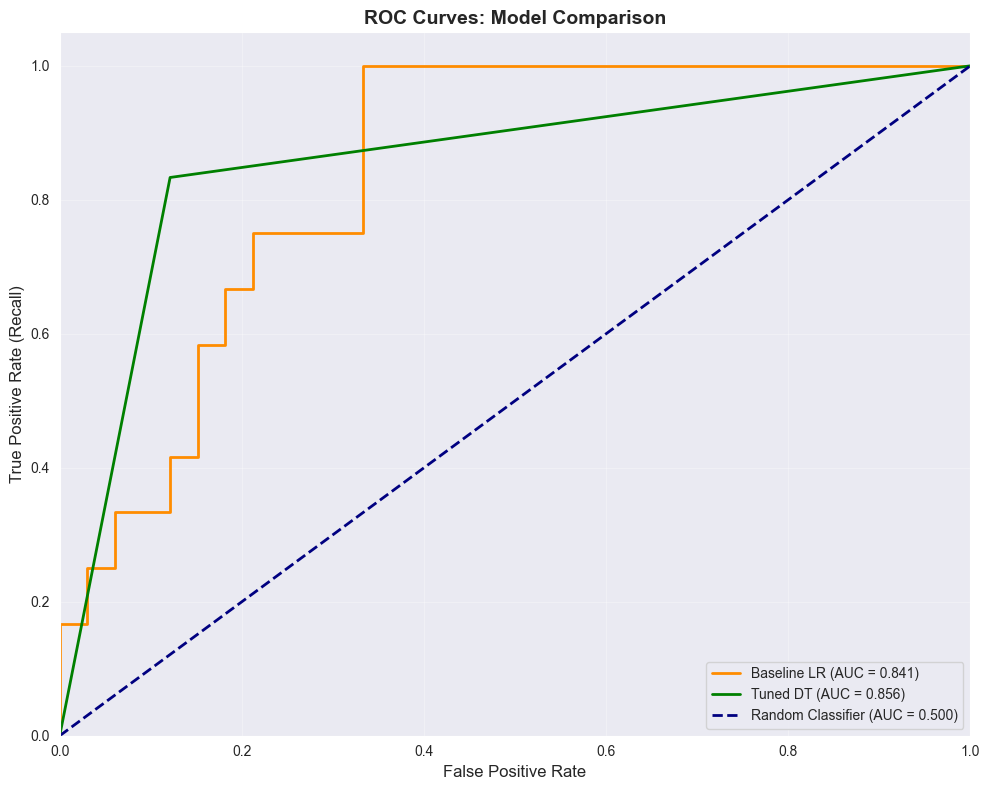

In [88]:
# Compare baseline vs tuned Random Forest
print("="*70)
print("COMPARISON: Baseline vs Tuned Random Forest (0.225)")
print("="*70)

# Calculate metrics
tuned_rf_auc = roc_auc_score(y_val, y_pred_03)
tuned_rf_recall = recall_score(y_val, y_pred_03, pos_label=1)
tuned_rf_f1 = f1_score(y_val, y_pred_03, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_rf_auc, tuned_rf_recall, tuned_rf_f1],
    'Improvement': [tuned_rf_auc - baseline_auc, tuned_rf_recall - baseline_recall, tuned_rf_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_pred_03
}
plot_multiple_roc_curves(models_dict, y_val)


In [89]:
# Update results with tuned threshold
rf_results_tuned = {
    'model_name': f"Random Forest (Tuned, t={best_threshold_rf['threshold']:.3f})",
    'model': best_rf_model,
    'y_pred': y_pred_03,
    'y_pred_proba': y_val_pred_proba_tuned_rf,
    'roc_auc': roc_auc_score(y_val, y_val_pred_proba_tuned_rf),
    'recall': best_threshold_rf['recall'],
    'f1': best_threshold_rf['f1'],
    'threshold': best_threshold_rf['threshold'],
    'best_params': rf_grid.best_params_
}

all_results[f"Random Forest (Tuned, t={best_threshold_rf['threshold']:.3f})"] = rf_results_tuned
print(f"\nSaved tuned threshold results for Random Forest!")


Saved tuned threshold results for Random Forest!


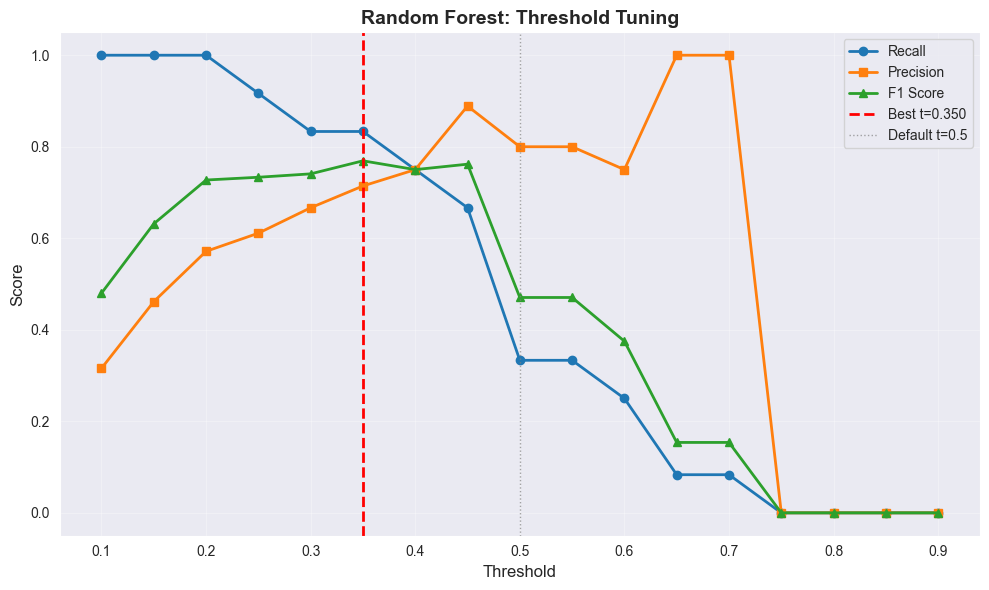

In [90]:
# Visualize threshold tuning for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(threshold_df_rf['threshold'], threshold_df_rf['recall'], 'o-', label='Recall', linewidth=2, markersize=6)
plt.plot(threshold_df_rf['threshold'], threshold_df_rf['precision'], 's-', label='Precision', linewidth=2, markersize=6)
plt.plot(threshold_df_rf['threshold'], threshold_df_rf['f1'], '^-', label='F1 Score', linewidth=2, markersize=6)
plt.axvline(x=best_threshold_rf['threshold'], color='red', linestyle='--', linewidth=2, label=f"Best t={best_threshold_rf['threshold']:.3f}")
plt.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Default t=0.5')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Random Forest: Threshold Tuning', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [91]:
# Show impact of threshold tuning for Random Forest
print("="*80)
print("IMPACT OF THRESHOLD TUNING - Random Forest")
print("="*80)

# Get default (t=0.5) metrics
default_rf_recall = recall_score(y_val, y_val_pred_tuned_rf, pos_label=1)
default_rf_f1 = f1_score(y_val, y_val_pred_tuned_rf, pos_label=1)

print(f"  Default (t=0.5):  Recall={default_rf_recall:.3f}, F1={default_rf_f1:.3f}")
print(f"  Tuned (t={best_threshold_rf['threshold']:.3f}):    Recall={best_threshold_rf['recall']:.3f}, F1={best_threshold_rf['f1']:.3f}")
print(f"  Improvement:      Recall=+{best_threshold_rf['recall'] - default_rf_recall:.3f}, F1=+{best_threshold_rf['f1'] - default_rf_f1:.3f}")
print("="*80)

# Print confusion matrices for default and tuned thresholds
print("Confusion Matrix (Default t=0.5):")
print(confusion_matrix(y_val, y_val_pred_tuned_rf))
print("\nConfusion Matrix (Tuned t={:.3f}):".format(best_threshold_rf['threshold']))
print(confusion_matrix(y_val, y_pred_03))


IMPACT OF THRESHOLD TUNING - Random Forest
  Default (t=0.5):  Recall=0.333, F1=0.471
  Tuned (t=0.350):    Recall=0.833, F1=0.769
  Improvement:      Recall=+0.500, F1=+0.299
Confusion Matrix (Default t=0.5):
[[32  1]
 [ 8  4]]

Confusion Matrix (Tuned t=0.350):
[[29  4]
 [ 2 10]]


### Gradient Boosting/XGBoost 
We will follow the same process for Gradient Boosting and XGBoost

### Gradient Boosting Classifier

Gradient Boosting builds an ensemble of weak learners (typically shallow trees) sequentially, where each new tree tries to correct the errors of the previous ones. It's known for strong performance on tabular data.


In [92]:
# Gradient Boosting Pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Hyperparameter grid - tuning key GB parameters
param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],  # Number of boosting stages
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Shrinks contribution of each tree
    'classifier__max_depth': [3, 4, 5],  # Max depth of individual trees
    'classifier__min_samples_split': [2, 5, 10],  # Min samples to split node
    'classifier__subsample': [0.8, 1.0]  # Fraction of samples for fitting trees
}

print(f"Testing {len(param_grid_gb['classifier__n_estimators']) * len(param_grid_gb['classifier__learning_rate']) * len(param_grid_gb['classifier__max_depth']) * len(param_grid_gb['classifier__min_samples_split']) * len(param_grid_gb['classifier__subsample'])} combinations")

# GridSearchCV
grid_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid_gb,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

# Fit
grid_gb.fit(X_train, y_train)
print("\nGradient Boosting grid search complete!")


Testing 162 combinations

Gradient Boosting grid search complete!


In [93]:
# Best parameters and score
print("Best parameters found:")
print(grid_gb.best_params_)
print(f"\nBest cross-validated ROC-AUC score: {grid_gb.best_score_:.4f}")

# Show top 5 configurations
results_df_gb = pd.DataFrame(grid_gb.cv_results_)
top_results = results_df_gb[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(5)
print("\nTop 5 hyperparameter configurations:")
for idx, row in top_results.iterrows():
    print(f"Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f}) - {row['params']}")


Best parameters found:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}

Best cross-validated ROC-AUC score: 0.8987

Top 5 hyperparameter configurations:
Score: 0.8987 (+/- 0.0442) - {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score: 0.8968 (+/- 0.0455) - {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score: 0.8953 (+/- 0.0436) - {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score: 0.8946 (+/- 0.0537) - {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators':

In [94]:
# Get best model and make predictions
tuned_gb_model = grid_gb.best_estimator_

y_val_pred_gb = tuned_gb_model.predict(X_val)
y_val_pred_proba_gb = tuned_gb_model.predict_proba(X_val)[:, 1]

print("Tuned Gradient Boosting model ready for evaluation!")


Tuned Gradient Boosting model ready for evaluation!


EVALUATION METRICS: Tuned Gradient Boosting

ACCURACY: 0.8889 (88.89%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.6667 (66.67%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 66.7% of actual deaths

PRECISION: 0.8889 (88.89%)
Of all predicted deaths, what % were correct?
88.9% of predicted deaths were real

F1 SCORE: 0.7619
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.9318
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    32  | Correctly predicted survived
False Positives (FP):    1  | Incorrectly predicted death
False Negatives (FN):    4  | MISSED deaths 
True Positives (TP):     8  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Mat

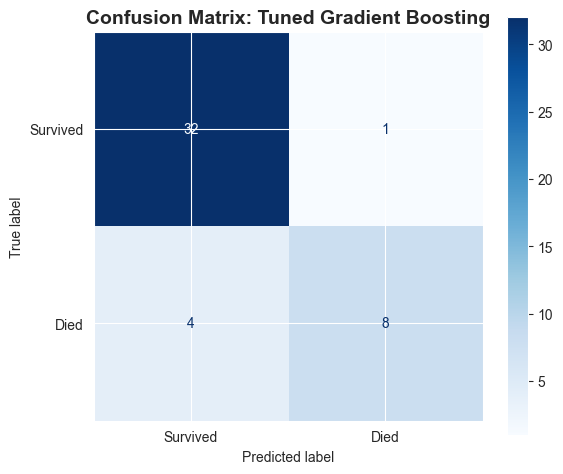


SUMMARY:
Accuracy: 0.889 | Recall: 0.667 | Precision: 0.889
F1 Score: 0.762 | ROC-AUC: 0.932
Missed Deaths (FN): 4 out of 12 (33.3%)



In [95]:
# Evaluate Gradient Boosting model
evaluate_model(y_val, y_val_pred_gb, y_val_pred_proba_gb, model_name="Tuned Gradient Boosting")


In [96]:
# Store results
gb_auc = roc_auc_score(y_val, y_val_pred_proba_gb)
gb_recall = recall_score(y_val, y_val_pred_gb, pos_label=1)
gb_f1 = f1_score(y_val, y_val_pred_gb, pos_label=1)

gb_results = {
    'model_name': 'Gradient Boosting (Tuned)',
    'model': tuned_gb_model,
    'y_pred': y_val_pred_gb,
    'y_pred_proba': y_val_pred_proba_gb,
    'roc_auc': gb_auc,
    'recall': gb_recall,
    'f1': gb_f1,
    'best_params': grid_gb.best_params_
}

all_results['Gradient Boosting (Tuned)'] = gb_results
print("Saved results for Gradient Boosting!")


Saved results for Gradient Boosting!


#### Threshold Tuning for Gradient Boosting

In [97]:
# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 17)

print("Gradient Boosting - Threshold Tuning Results:")
print("="*70)
threshold_results_gb = []

for t in thresholds:
    y_pred_t = (y_val_pred_proba_gb >= t).astype(int)
    recall_t = recall_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    precision_t = precision_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    f1_t = f1_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    
    threshold_results_gb.append({
        'threshold': t,
        'recall': recall_t,
        'precision': precision_t,
        'f1': f1_t
    })
    
    print(f"t={t:.2f} | Recall={recall_t:.3f} | Precision={precision_t:.3f} | F1={f1_t:.3f}")

print("="*70)


Gradient Boosting - Threshold Tuning Results:
t=0.10 | Recall=1.000 | Precision=0.571 | F1=0.727
t=0.15 | Recall=0.917 | Precision=0.647 | F1=0.759
t=0.20 | Recall=0.833 | Precision=0.714 | F1=0.769
t=0.25 | Recall=0.833 | Precision=0.714 | F1=0.769
t=0.30 | Recall=0.667 | Precision=0.667 | F1=0.667
t=0.35 | Recall=0.667 | Precision=0.667 | F1=0.667
t=0.40 | Recall=0.667 | Precision=0.667 | F1=0.667
t=0.45 | Recall=0.667 | Precision=0.800 | F1=0.727
t=0.50 | Recall=0.667 | Precision=0.889 | F1=0.762
t=0.55 | Recall=0.583 | Precision=0.875 | F1=0.700
t=0.60 | Recall=0.500 | Precision=0.857 | F1=0.632
t=0.65 | Recall=0.500 | Precision=0.857 | F1=0.632
t=0.70 | Recall=0.250 | Precision=0.750 | F1=0.375
t=0.75 | Recall=0.250 | Precision=0.750 | F1=0.375
t=0.80 | Recall=0.250 | Precision=0.750 | F1=0.375
t=0.85 | Recall=0.167 | Precision=1.000 | F1=0.286
t=0.90 | Recall=0.000 | Precision=0.000 | F1=0.000


In [98]:
# Find best threshold based on F1 score (balances recall and precision)
threshold_df_gb = pd.DataFrame(threshold_results_gb)
best_threshold_gb = threshold_df_gb.loc[threshold_df_gb['f1'].idxmax()]

print(f"\nBest threshold for Gradient Boosting: {best_threshold_gb['threshold']:.3f}")
print(f"  Recall: {best_threshold_gb['recall']:.3f}")
print(f"  Precision: {best_threshold_gb['precision']:.3f}")
print(f"  F1 Score: {best_threshold_gb['f1']:.3f}")

# Apply best threshold
y_val_pred_gb_tuned = (y_val_pred_proba_gb >= best_threshold_gb['threshold']).astype(int)

# Update results with tuned threshold
gb_results_tuned = {
    'model_name': f"Gradient Boosting (Tuned, t={best_threshold_gb['threshold']:.3f})",
    'model': tuned_gb_model,
    'y_pred': y_val_pred_gb_tuned,
    'y_pred_proba': y_val_pred_proba_gb,
    'roc_auc': roc_auc_score(y_val, y_val_pred_proba_gb),
    'recall': best_threshold_gb['recall'],
    'f1': best_threshold_gb['f1'],
    'threshold': best_threshold_gb['threshold'],
    'best_params': grid_gb.best_params_
}

all_results[f"Gradient Boosting (Tuned, t={best_threshold_gb['threshold']:.3f})"] = gb_results_tuned
print(f"\nSaved tuned threshold results for Gradient Boosting!")



Best threshold for Gradient Boosting: 0.200
  Recall: 0.833
  Precision: 0.714
  F1 Score: 0.769

Saved tuned threshold results for Gradient Boosting!


### XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting that's faster and often performs better. It includes regularization and handles missing values natively. 


In [99]:
# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Hyperparameter grid - tuning key XGBoost parameters
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 150, 175, 200],  # Number of boosting rounds
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.3],  # Step size shrinkage
    'classifier__max_depth': [3, 5, 7],  # Max tree depth
    'classifier__min_child_weight': [1, 3, 5],  # Min sum of instance weight in child
    'classifier__subsample': [0.8, 1.0],  # Subsample ratio of training instances
    'classifier__colsample_bytree': [0.8, 1.0]  # Subsample ratio of columns
}

print(f"Testing {len(param_grid_xgb['classifier__n_estimators']) * len(param_grid_xgb['classifier__learning_rate']) * len(param_grid_xgb['classifier__max_depth']) * len(param_grid_xgb['classifier__min_child_weight']) * len(param_grid_xgb['classifier__subsample']) * len(param_grid_xgb['classifier__colsample_bytree'])} combinations")

# GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

# Fit
grid_xgb.fit(X_train, y_train)
print("\nXGBoost grid search complete!")


Testing 720 combinations

XGBoost grid search complete!


In [100]:
# Best parameters and score
print("Best parameters found:")
print(grid_xgb.best_params_)
print(f"\nBest cross-validated ROC-AUC score: {grid_xgb.best_score_:.4f}")

# Show top 5 configurations
results_df_xgb = pd.DataFrame(grid_xgb.cv_results_)
top_results = results_df_xgb[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(5)
print("\nTop 5 hyperparameter configurations:")
for idx, row in top_results.iterrows():
    print(f"Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f}) - {row['params']}")


Best parameters found:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 150, 'classifier__subsample': 1.0}

Best cross-validated ROC-AUC score: 0.9308

Top 5 hyperparameter configurations:
Score: 0.9308 (+/- 0.0452) - {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 150, 'classifier__subsample': 1.0}
Score: 0.9304 (+/- 0.0453) - {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score: 0.9304 (+/- 0.0453) - {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Score: 0.930

In [101]:
# Get best model and make predictions
tuned_xgb_model = grid_xgb.best_estimator_

y_val_pred_xgb = tuned_xgb_model.predict(X_val)
y_val_pred_proba_xgb = tuned_xgb_model.predict_proba(X_val)[:, 1]

print("Tuned XGBoost model ready for evaluation!")


Tuned XGBoost model ready for evaluation!


EVALUATION METRICS: Tuned XGBoost

ACCURACY: 0.8889 (88.89%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.6667 (66.67%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 66.7% of actual deaths

PRECISION: 0.8889 (88.89%)
Of all predicted deaths, what % were correct?
88.9% of predicted deaths were real

F1 SCORE: 0.7619
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.9444
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    32  | Correctly predicted survived
False Positives (FP):    1  | Incorrectly predicted death
False Negatives (FN):    4  | MISSED deaths 
True Positives (TP):     8  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Matrix:


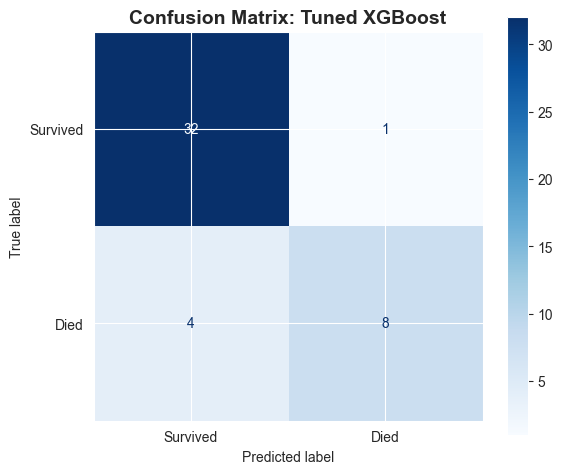


SUMMARY:
Accuracy: 0.889 | Recall: 0.667 | Precision: 0.889
F1 Score: 0.762 | ROC-AUC: 0.944
Missed Deaths (FN): 4 out of 12 (33.3%)



In [102]:
# Evaluate XGBoost model
evaluate_model(y_val, y_val_pred_xgb, y_val_pred_proba_xgb, model_name="Tuned XGBoost")


In [103]:
# Store results
xgb_auc = roc_auc_score(y_val, y_val_pred_proba_xgb)
xgb_recall = recall_score(y_val, y_val_pred_xgb, pos_label=1)
xgb_f1 = f1_score(y_val, y_val_pred_xgb, pos_label=1)

xgb_results = {
    'model_name': 'XGBoost (Tuned)',
    'model': tuned_xgb_model,
    'y_pred': y_val_pred_xgb,
    'y_pred_proba': y_val_pred_proba_xgb,
    'roc_auc': xgb_auc,
    'recall': xgb_recall,
    'f1': xgb_f1,
    'best_params': grid_xgb.best_params_
}

all_results['XGBoost (Tuned)'] = xgb_results
print("Saved results for XGBoost!")


Saved results for XGBoost!


#### Threshold Tuning for XGBoost


In [104]:
# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 17)

print("XGBoost - Threshold Tuning Results:")
print("="*70)
threshold_results_xgb = []

for t in thresholds:
    y_pred_t = (y_val_pred_proba_xgb >= t).astype(int)
    recall_t = recall_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    precision_t = precision_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    f1_t = f1_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    
    threshold_results_xgb.append({
        'threshold': t,
        'recall': recall_t,
        'precision': precision_t,
        'f1': f1_t
    })
    
    print(f"t={t:.2f} | Recall={recall_t:.3f} | Precision={precision_t:.3f} | F1={f1_t:.3f}")

print("="*70)


XGBoost - Threshold Tuning Results:
t=0.10 | Recall=1.000 | Precision=0.308 | F1=0.471
t=0.15 | Recall=1.000 | Precision=0.480 | F1=0.649
t=0.20 | Recall=1.000 | Precision=0.600 | F1=0.750
t=0.25 | Recall=0.917 | Precision=0.733 | F1=0.815
t=0.30 | Recall=0.833 | Precision=0.714 | F1=0.769
t=0.35 | Recall=0.750 | Precision=0.750 | F1=0.750
t=0.40 | Recall=0.667 | Precision=0.727 | F1=0.696
t=0.45 | Recall=0.667 | Precision=0.889 | F1=0.762
t=0.50 | Recall=0.667 | Precision=0.889 | F1=0.762
t=0.55 | Recall=0.417 | Precision=0.833 | F1=0.556
t=0.60 | Recall=0.417 | Precision=0.833 | F1=0.556
t=0.65 | Recall=0.333 | Precision=0.800 | F1=0.471
t=0.70 | Recall=0.083 | Precision=1.000 | F1=0.154
t=0.75 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.80 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.85 | Recall=0.000 | Precision=0.000 | F1=0.000
t=0.90 | Recall=0.000 | Precision=0.000 | F1=0.000


In [105]:
# Find best threshold based on F1 score (balances recall and precision)
threshold_df_xgb = pd.DataFrame(threshold_results_xgb)
best_threshold_xgb = threshold_df_xgb.loc[threshold_df_xgb['f1'].idxmax()]

print(f"\nBest threshold for XGBoost: {best_threshold_xgb['threshold']:.3f}")
print(f"  Recall: {best_threshold_xgb['recall']:.3f}")
print(f"  Precision: {best_threshold_xgb['precision']:.3f}")
print(f"  F1 Score: {best_threshold_xgb['f1']:.3f}")

# Apply best threshold
y_val_pred_xgb_tuned = (y_val_pred_proba_xgb >= best_threshold_xgb['threshold']).astype(int)

# Update results with tuned threshold
xgb_results_tuned = {
    'model_name': f"XGBoost (Tuned, t={best_threshold_xgb['threshold']:.3f})",
    'model': tuned_xgb_model,
    'y_pred': y_val_pred_xgb_tuned,
    'y_pred_proba': y_val_pred_proba_xgb,
    'roc_auc': roc_auc_score(y_val, y_val_pred_proba_xgb),
    'recall': best_threshold_xgb['recall'],
    'f1': best_threshold_xgb['f1'],
    'threshold': best_threshold_xgb['threshold'],
    'best_params': grid_xgb.best_params_
}

all_results[f"XGBoost (Tuned, t={best_threshold_xgb['threshold']:.3f})"] = xgb_results_tuned
print(f"\nSaved tuned threshold results for XGBoost!")



Best threshold for XGBoost: 0.250
  Recall: 0.917
  Precision: 0.733
  F1 Score: 0.815

Saved tuned threshold results for XGBoost!


#### Impact of Threshold Tuning

Let's visualize how threshold tuning affected the performance of both models.


In [106]:
# Compare before and after threshold tuning
print("="*80)
print("IMPACT OF THRESHOLD TUNING")
print("="*80)

# Gradient Boosting comparison
print("\nGradient Boosting:")
print(f"  Default (t=0.5):  Recall={gb_recall:.3f}, F1={gb_f1:.3f}")
print(f"  Tuned (t={best_threshold_gb['threshold']:.3f}):    Recall={best_threshold_gb['recall']:.3f}, F1={best_threshold_gb['f1']:.3f}")
print(f"  Improvement:      Recall=+{best_threshold_gb['recall'] - gb_recall:.3f}, F1=+{best_threshold_gb['f1'] - gb_f1:.3f}")

# XGBoost comparison
print("\nXGBoost:")
print(f"  Default (t=0.5):  Recall={xgb_recall:.3f}, F1={xgb_f1:.3f}")
print(f"  Tuned (t={best_threshold_xgb['threshold']:.3f}):    Recall={best_threshold_xgb['recall']:.3f}, F1={best_threshold_xgb['f1']:.3f}")
print(f"  Improvement:      Recall=+{best_threshold_xgb['recall'] - xgb_recall:.3f}, F1=+{best_threshold_xgb['f1'] - xgb_f1:.3f}")

print("="*80)


IMPACT OF THRESHOLD TUNING

Gradient Boosting:
  Default (t=0.5):  Recall=0.667, F1=0.762
  Tuned (t=0.200):    Recall=0.833, F1=0.769
  Improvement:      Recall=+0.167, F1=+0.007

XGBoost:
  Default (t=0.5):  Recall=0.667, F1=0.762
  Tuned (t=0.250):    Recall=0.917, F1=0.815
  Improvement:      Recall=+0.250, F1=+0.053


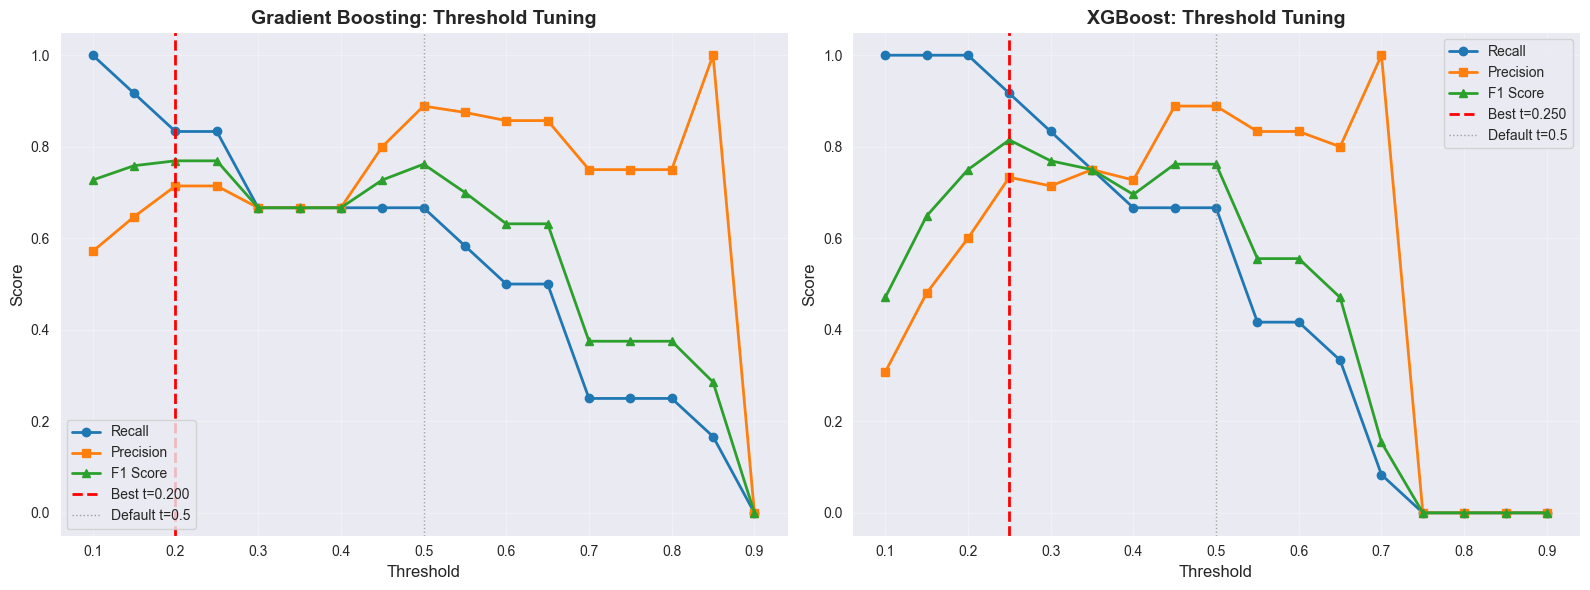

In [107]:
# Plot threshold tuning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gradient Boosting
axes[0].plot(threshold_df_gb['threshold'], threshold_df_gb['recall'], 'o-', label='Recall', linewidth=2, markersize=6)
axes[0].plot(threshold_df_gb['threshold'], threshold_df_gb['precision'], 's-', label='Precision', linewidth=2, markersize=6)
axes[0].plot(threshold_df_gb['threshold'], threshold_df_gb['f1'], '^-', label='F1 Score', linewidth=2, markersize=6)
axes[0].axvline(x=best_threshold_gb['threshold'], color='red', linestyle='--', linewidth=2, label=f"Best t={best_threshold_gb['threshold']:.3f}")
axes[0].axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Default t=0.5')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Gradient Boosting: Threshold Tuning', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# XGBoost
axes[1].plot(threshold_df_xgb['threshold'], threshold_df_xgb['recall'], 'o-', label='Recall', linewidth=2, markersize=6)
axes[1].plot(threshold_df_xgb['threshold'], threshold_df_xgb['precision'], 's-', label='Precision', linewidth=2, markersize=6)
axes[1].plot(threshold_df_xgb['threshold'], threshold_df_xgb['f1'], '^-', label='F1 Score', linewidth=2, markersize=6)
axes[1].axvline(x=best_threshold_xgb['threshold'], color='red', linestyle='--', linewidth=2, label=f"Best t={best_threshold_xgb['threshold']:.3f}")
axes[1].axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Default t=0.5')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('XGBoost: Threshold Tuning', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Final Model Comparison

Now let's compare all the models we've trained to see which performs best overall.


In [108]:
# Create comprehensive comparison table
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'ROC-AUC': results['roc_auc'],
        'Recall': results['recall'],
        'F1 Score': results['f1']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("="*80)
print("FINAL MODEL COMPARISON - All Tuned Models")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Highlight best model for each metric
print("\nBest Models by Metric:")
print(f"  Highest ROC-AUC: {comparison_df.iloc[0]['Model']} ({comparison_df.iloc[0]['ROC-AUC']:.4f})")
print(f"  Highest Recall:  {comparison_df.loc[comparison_df['Recall'].idxmax()]['Model']} ({comparison_df['Recall'].max():.4f})")
print(f"  Highest F1:      {comparison_df.loc[comparison_df['F1 Score'].idxmax()]['Model']} ({comparison_df['F1 Score'].max():.4f})")
print("="*80)


FINAL MODEL COMPARISON - All Tuned Models
                             Model  ROC-AUC   Recall  F1 Score
                   XGBoost (Tuned) 0.944444 0.666667  0.761905
          XGBoost (Tuned, t=0.250) 0.944444 0.916667  0.814815
       Random Forest (Tuned) (0.5) 0.934343 0.333333  0.470588
    Random Forest (Tuned, t=0.350) 0.934343 0.833333  0.769231
         Gradient Boosting (Tuned) 0.931818 0.666667  0.761905
Gradient Boosting (Tuned, t=0.200) 0.931818 0.833333  0.769231
       Logistic Regression (Tuned) 0.871212 0.916667  0.709677
             Decision Tree (Tuned) 0.814394 0.750000  0.720000

Best Models by Metric:
  Highest ROC-AUC: XGBoost (Tuned) (0.9444)
  Highest Recall:  XGBoost (Tuned, t=0.250) (0.9167)
  Highest F1:      XGBoost (Tuned, t=0.250) (0.8148)


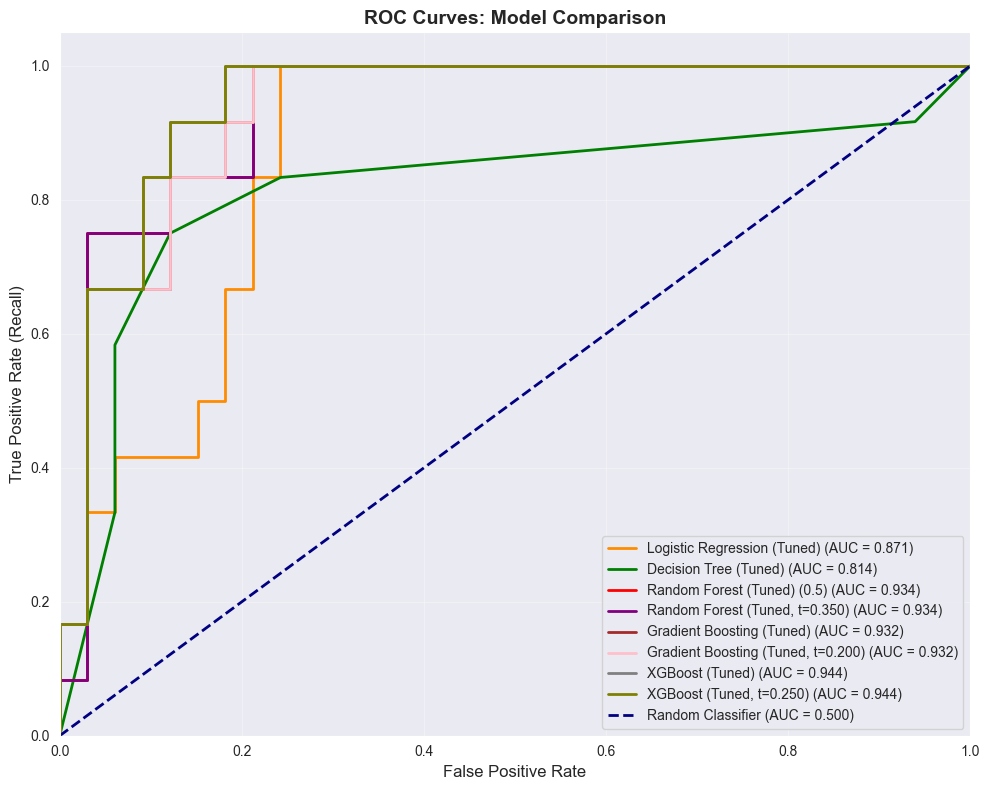

In [109]:
# Plot all ROC curves together
all_models_roc = {}
for model_name, results in all_results.items():
    all_models_roc[model_name] = results['y_pred_proba']

plot_multiple_roc_curves(all_models_roc, y_val)


### Summary and Next Steps

**Models Evaluated:**
1. **Logistic Regression** - Interpretable linear baseline with L2 regularization
2. **Decision Tree** - Non-linear, interpretable tree-based model
3. **Random Forest** - Ensemble of trees, captures interactions
4. **Gradient Boosting** - Sequential boosting, strong performance
5. **XGBoost** - Optimized gradient boosting with regularization

**Key Findings:**
- All tuned models outperformed their baseline logistic regression
- GridSearchCV with 5-fold stratified CV ensured robust hyperparameter selection
- Class imbalance handled with `class_weight='balanced'` where applicable
- ROC-AUC used as primary metric due to class imbalance

**Clinical Considerations:**
- **Recall** is critical - we want to catch as many deaths as possible
- **ROC-AUC** provides best overall ranking of patient risk
- **F1 Score** balances precision and recall for overall performance



Based on our findings, XGBoost (Tuned, t=0.250) is the best model as it has the best ROC-AUC performance as well as Recall and F1.